# 네이버 영화 리뷰 감성 분류
- 출처: [WikiDocs](https://wikidocs.net/44249)
- 데이터 다운로드 링크: https://github.com/e9t/nsmc/

## 1. 네이버 영화 리뷰 데이터에 대한 이해

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
from konlpy.tag import Okt
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
## 관리자 cmd --> conda activate tf2 --> pip install konlpy

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\pydot.py:18: UserWarning: Couldn't import dot_parser, loading of dot files will not be possible.
  "Couldn't import dot_parser, "
Using TensorFlow backend.


In [3]:
train_data= pd.read_table('data/ratings_train.txt')
test_data= pd.read_table('data/ratings_test.txt')

In [4]:
# 영화 리뷰 개수
len(train_data), len(test_data)

(150000, 50000)

In [5]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


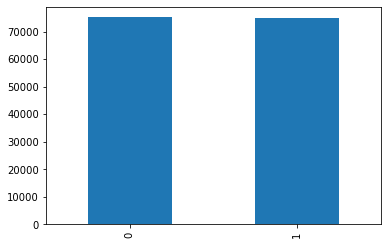

In [7]:
# 0 - 부정, 1 - 긍정
train_data['label'].value_counts().plot(kind='bar')

In [8]:
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [9]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

True
True


In [10]:
# 어떤 열에 존재하는지 확인
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


In [11]:
print(test_data.isnull().sum())

id          0
document    3
label       0
dtype: int64


In [12]:
# Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [13]:
# Null 값을 가진 샘플을 제거
train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
test_data=test_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


## 2. 전처리

In [15]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [16]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [19]:
# 토큰화와 불용어 제거
import tqdm.notebook as tn
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train=[]
for sentence in tqdm.notebook.tqdm(train_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [20]:
X_test=[]
for sentence in tqdm.notebook.tqdm(test_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [21]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [22]:
# 정수 인코딩
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
X_train[:3]

[[50, 457, 16, 260, 660],
 [919, 459, 41, 599, 1, 214, 1455, 24, 965, 676, 19],
 [386, 2452, 25024, 2319, 5676, 2, 221, 9]]

In [24]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.64700156671889


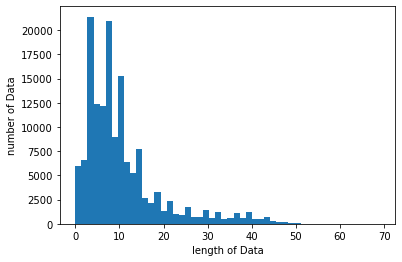

In [25]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [26]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [27]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 3. LSTM으로 감성 분류하기

In [28]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

In [29]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [31]:
from keras.callbacks import ModelCheckpoint
modelpath = "model/naver-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [32]:
history = model.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 119996 samples, validate on 29999 samples
Epoch 1/4
119996/119996 [==============================] - 128s 1ms/step - loss: 0.3890 - accuracy: 0.8210 - val_loss: 0.3474 - val_accuracy: 0.8454

Epoch 00001: val_loss improved from inf to 0.34743, saving model to model/naver-01-0.3474.hdf5
Epoch 2/4
119996/119996 [==============================] - 128s 1ms/step - loss: 0.3277 - accuracy: 0.8570 - val_loss: 0.3330 - val_accuracy: 0.8535

Epoch 00002: val_loss improved from 0.34743 to 0.33296, saving model to model/naver-02-0.3330.hdf5
Epoch 3/4
119996/119996 [==============================] - 128s 1ms/step - loss: 0.3006 - accuracy: 0.8716 - val_loss: 0.3267 - val_accuracy: 0.8588

Epoch 00003: val_loss improved from 0.33296 to 0.32672, saving model to model/naver-03-0.3267.hdf5
Epoch 4/4
119996/119996 [==============================] - 128s 1ms/step - loss: 0.2779 - accuracy: 0.8842 - val_loss: 0.3337 - val_accuracy: 0.8572

Epoch 00004: val_loss did not improve from 0.32672


In [33]:
# Best Model 선택
from keras.models import load_model
del model
model = load_model('model/naver-03-0.3267.hdf5')

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, verbose=2)[1]))


 테스트 정확도: 0.8540


In [35]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

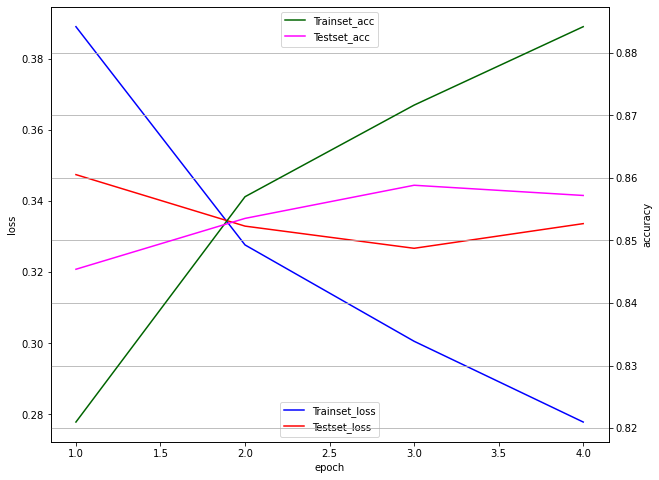

In [36]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()